# 초기설정

In [1]:
%pip install moviepy jiwer matplotlib pandas openai-whisper
%pip install --upgrade google-cloud-speech
%pip install python-dotenv
%pip install boto3
%pip install azure-cognitiveservices-speech
%pip install pydub
%pip install -U openai-whisper
%pip install yt-dlp
%pip install google-cloud-storage
%pip install Soundfile

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from dotenv import load_dotenv
import time
import wave
from moviepy import VideoFileClip
import jiwer
import matplotlib.pyplot as plt
import pandas as pd
import requests
from pydub import AudioSegment
import json
from IPython.display import display
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import glob
import soundfile as sf
# STT 라이브러리 설치
from google.cloud import speech # google
import whisper # whisper
import boto3
from botocore.client import Config
import uuid
import azure.cognitiveservices.speech as speechsdk
import whisper
import torch
from google.cloud import storage
# 기본 설정
load_dotenv()

True

In [3]:
%pip show moviepy

Name: moviepy
Version: 2.1.2
Summary: Video editing with Python
Home-page: 
Author: Zulko 2024
Author-email: 
License: MIT License
Location: c:\Users\inwoo\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: decorator, imageio, imageio_ffmpeg, numpy, pillow, proglog, python-dotenv
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
service_costs = {
    "CLOVA": 0.01,      # 네이버 CLOVA: 기본 모드 예시 (15초당 약 0.01)
    "Whisper": 0,   # OpenAI Whisper API 사용 시: 약 0.006 (분당 비용 예시)
    "Google STT": 0.006,  # Google STT: 기본 모드 시 약 0.006
    "AWS": 0.0075,      # AWS Transcribe: 기본 모드 시 약 0.0075
    "Azure": 0.01,      # Microsoft Azure Speech: 기본 모드 시 약 0.01
}

customization_capability = {
    "CLOVA": False,     # 네이버 CLOVA: 기본 모델만 제공되어 커스터마이징 지원 안 함
    "Whisper": False,   # Whisper: 공식 커스터마이징 지원 없음 (오픈소스 모델이라 직접 파인튜닝은 가능하나 별도 지원 미제공)
    "Google STT": True, # Google STT: phrase hints 등 제한적 커스터마이징 지원
    "AWS": True,        # AWS Transcribe: Custom Vocabulary 및 Custom Language Model 지원
    "Azure": True,      # Azure Speech: Custom Speech 기능 등으로 커스터마이징 지원
}

speaker_classification = {
    "CLOVA": False,
    "Whisper": False,   
    "Google STT": True, 
    "AWS": True,        
    "Azure": True, 
}

In [6]:
# 사전 준비
print("🔧 Whisper 모델 로딩...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
whisper_model = whisper.load_model("medium", device=device)

print("🔧 Google STT 클라이언트 초기화...")
google_client = speech.SpeechClient()

print("🔧 AWS 클라이언트 초기화...")
aws_client = boto3.client('transcribe',
                          region_name='us-west-2',
                          aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
                          aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

print("🔧 Azure STT 설정 초기화...")
azure_config = speechsdk.SpeechConfig(
    subscription=os.getenv("AZURE_SPEECH_KEY"),
    region=os.getenv("AZURE_SPEECH_REGION")
)

🔧 Whisper 모델 로딩...
🔧 Google STT 클라이언트 초기화...
🔧 AWS 클라이언트 초기화...
🔧 Azure STT 설정 초기화...


# 필요함수

## WER 계산 함수

In [4]:
# WER 계산 함수 (jiwer 라이브러리 사용)
def calculate_wer(reference, hypothesis):
    # 텍스트를 소문자로 변환, 문장부호 제거, 양쪽 공백 제거 등을 적용하여 비교
    transformation = jiwer.Compose([
        jiwer.ToLowerCase(), 
        jiwer.RemovePunctuation(), 
        jiwer.Strip(),
        jiwer.ReduceToListOfListOfWords()
    ])
    wer = jiwer.wer(reference, hypothesis, truth_transform=transformation,
                    hypothesis_transform=transformation)
    return wer

In [5]:
# 도움 함수: 오디오 길이(초) 반환 (wave 모듈 활용)
def get_audio_duration(audio_path):
    with wave.open(audio_path, 'rb') as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    return duration
    # audio = AudioSegment.from_file(audio_path, format="mp3")
    # return len(audio) / 1000.0  # milliseconds to seconds

## script 전처리 함수

In [6]:
p_double = re.compile(r'\(([^)]+)\)/\([^)]+\)')
p_mention = re.compile(r'@([가-힣]+)\d*')
p_slash = re.compile(r'/\(([^)]+)\)*')
p_del1 = re.compile(r'\(*')
p_del2 = re.compile(r'\)*')
p_speaker = re.compile(r'\b\d+:\s*')
p_space = re.compile(r'\s+')

def clean_line(line: str) -> str:
    # 1) 이중 괄호 표기: (A)/(B) → A
    line = p_double.sub(r'\1', line)
    # 2) 멘션 삭제: @이름10 등
    line = p_mention.sub(r'\1', line)
    # 3) /(?) 제거: "/(idiom)" → ""
    line = p_slash.sub('', line)
    # 괄호 삭제
    line = p_del1.sub('', line)
    line = p_del2.sub('', line)
    # 4) 화자 번호 삭제: "4:" or "10:" etc.
    line = p_speaker.sub('', line)
    # 6) 중복 공백→한 칸
    line = p_space.sub(' ', line).strip()
    return line


def clean_text(infile: str, outfile: str):
    infile = "text.txt"
    outfile = "text.txt"

    with open(infile, 'r', encoding='utf-8') as fin:
        raws = [line.rstrip('\n') for line in fin if line.strip()]
    rst = []
    for s in raws:
        out = clean_line(s)
        if out:
            rst.append(out + '\n')
            print(out)
    with open(outfile, 'w', encoding='utf-8') as fout:
        fout.writelines(rst)

# stt 호출

In [7]:
# STT 시스템 API 호출 (각 함수 내에서 실제 API 연동 코드로 대체할 것)
def stt_clova(audio_path: str):

    """
    Clova Speech Upload Recognition을 requests만으로 실행하는 함수

    """
    api_url = os.getenv("CLOVA_CLIENT_URL")
    api_key = os.getenv("CLOVA_CLIENT_SECRET")

    URL = f'{api_url}/recognizer/upload'

    params = {
        "language": "ko-KR",
        "completion": "sync",
        "callback": "",
        "fullText": True,
        "diarization": {"enable": True}
    }

    with open(audio_path, "rb") as audio_file:
        files = {
            "media": ("media", audio_file, "application/octet-stream"),
            "params": (None, json.dumps(params), "application/json")
        }
        response = requests.post(
            URL,
            files=files,
            headers={
                "X-CLOVASPEECH-API-KEY": api_key
            },
            timeout=60
        )
    response.raise_for_status()

    result = response.json()

    if response.status_code == 200:
        print(f"clova {audio_path} complete")
        transcript = result["text"]
        return transcript
    else:
        print(f"API 요청 실패 (상태 코드 {response.status_code}):", response.text)
        return f"API 요청 실패 (상태 코드 {response.status_code}): {response.text}"

def stt_whisper(audio_path):
    # 2) 오디오 파일을 모델에 전달하여 transcription 수행
    result = whisper_model.transcribe(audio_path, language="ko")

    # 3) 텍스트 결과 추출
    transcript = result.get("text", "").strip()

    print("whisper complete")

    return transcript


def stt_google(audio_path: str):

    # ✅ GCS 업로드 설정
    bucket_name = "ondam_storage"
    destination_blob_name = f"stt_test/{os.path.basename(audio_path)}"
    blob_uri = f"gs://{bucket_name}/{destination_blob_name}"

    # ✅ GCS 업로드
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(audio_path)
    print(f"✅ GCS 업로드 완료: {blob_uri}")

    # ✅ STT 요청
    audio = speech.RecognitionAudio(uri=blob_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        language_code="ko-KR",
    )

    transcript = ""
    try:
        operation = speech.SpeechClient().long_running_recognize(config=config, audio=audio)
        response = operation.result(timeout=3600)
        transcript = " ".join([res.alternatives[0].transcript for res in response.results])
    except Exception as e:
        print("❌ Google STT 오류:", e)

    return transcript



def stt_aws(audio_path: str):
    region = "us-west-2"
    s3_bucket = "stt-test1324"
    s3_key = f"stt_test/{os.path.basename(audio_path)}"
    s3_uri = f"https://{s3_bucket}.s3.{region}.amazonaws.com/{s3_key}"

    # ✅ S3 업로드
    s3 = boto3.client('s3',
                      aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
                      aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))
    s3.upload_file(audio_path, s3_bucket, s3_key)
    print(f"✅ S3 업로드 완료: {s3_uri}")

    transcribe = boto3.client('transcribe',
                              region_name=region,
                              aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
                              aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

    job_name = f"transcription-job-{uuid.uuid4()}"
    transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': s3_uri},
        MediaFormat="wav",
        LanguageCode="ko-KR"
    )

    while True:
        status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
        job_status = status['TranscriptionJob']['TranscriptionJobStatus']
        print(f"현재 Job 상태: {job_status}")
        if job_status in ['COMPLETED', 'FAILED']:
            break
        time.sleep(10)

    transcript = ""
    if job_status == 'COMPLETED':
        transcript_uri = status['TranscriptionJob']['Transcript']['TranscriptFileUri']
        r = requests.get(transcript_uri)
        result_json = r.json()
        transcript = result_json.get('results', {}).get('transcripts', [{}])[0].get('transcript', '')
    else:
        transcript = "Transcription failed"

    return transcript



def stt_azure(audio_path):
    # Azure Speech 서비스 구독 키와 리전 설정 (환경 변수로 관리하는 것을 권장)
    subscription_key = os.getenv("AZURE_SPEECH_KEY")
    region = os.getenv("AZURE_SPEECH_REGION")

    # Speech 구성 생성
    speech_config = speechsdk.SpeechConfig(subscription=subscription_key, region=region)
    speech_config.speech_recognition_language = "ko-KR"  # 인식 언어 설정


    # 오디오 파일 로컬 경로에서 AudioConfig 생성
    audio_config = speechsdk.audio.AudioConfig(filename=audio_path)

    # SpeechRecognizer 생성: 음성 인식을 위한 구성 및 오디오 입력 설정
    recognizer = speechsdk.SpeechRecognizer(speech_config=speech_config, audio_config=audio_config)

    # 결과 누적할 리스트와 플래그
    transcripts = []
    done = False

    # 세션이 끝나면 done=True
    def stop_cb(evt):
        nonlocal done
        done = True

    # 인식된 부분이 나올 때마다 append
    recognizer.recognized.connect(
        lambda evt: transcripts.append(evt.result.text))
    # 에러나 세션 종료 이벤트 구독
    recognizer.session_stopped.connect(stop_cb)
    recognizer.canceled.connect(stop_cb)
    # 스트리밍 인식 시작
    recognizer.start_continuous_recognition()
    timeout = 1200
    while not done:
        # elapsed = time.time() - start
        # if elapsed > timeout:
        #     print(f"⚠️ 타임아웃({timeout}s) 도달, 인식 중단합니다.")
        #     recognizer.stop_continuous_recognition()
        #     break
        time.sleep(0.5)
    recognizer.stop_continuous_recognition()

    # 전체 텍스트 합치기
    transcript = " ".join(transcripts).strip()

    print("Full transcript:", transcript)
    return transcript 

# wer 검증 로직

In [8]:
STT_FUNCTIONS = {
    "CLOVA":      stt_clova,
    "Whisper":    stt_whisper,
    "Google STT": stt_google,
    "AWS":        stt_aws,
    "Azure":      stt_azure
}

# 메인 함수


In [9]:

def process_one_gpu(audio_dir, script_dir, basename, engine):
    """
    audio_dir: .wav 파일 폴더
    script_dir: 정답 스크립트(.txt) 폴더
    json_dir: 메타데이터 폴더
    basename: 확장자 제외 공통 파일명
    engine: STT_FUNCTIONS 키
    """
    t0 = time.time()

    # 1) 메타데이터(domain) 로드
    domain = os.path.basename(script_dir)

    # 2) 정답 스크립트(ground-truth) GPU 전처리
    txt_path = os.path.join(script_dir, f"{basename}.txt")
    with open(txt_path, encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    # 3) STT 호출
    audio_path = os.path.join(audio_dir, f"{basename}.wav")
    try:
        data, sr = sf.read(audio_path)
        duration_sec = len(data) / sr
    except Exception:
        duration_sec = 0

    stt_func = STT_FUNCTIONS[engine]
    t1 = time.time()
    hypothesis = stt_func(audio_path)               # 문자열 전체
    proc_time = time.time() - t1

    # 4) STT 결과 GPU 전처리
    # 하나로 합친 뒤 WER
    ref = " ".join(lines)
    hyp_txt = hypothesis.replace('\n', ' ')
    file_wer = calculate_wer(ref, hyp_txt)

    # 5) 비용 계산 (분당)
    cost = service_costs.get(engine, 0.0)
    cost_usd = round((duration_sec/60.0)*cost, 4)

    total_time = time.time() - t0

    return {
        'basename':      basename,
        'domain':        domain,
        'engine':        engine,
        'duration_sec':  round(duration_sec, 3),
        'wer':           round(file_wer, 3),
        'stt_time_sec':  round(proc_time, 3),
        'total_time_sec': round(total_time, 3),
        'cost_usd':      cost_usd,
        'transcript' : hypothesis
    }

In [23]:
def main_gpu(root_audio_dir, root_script_dir, engines, workers=None):
    results = []

    # 1) 분야별(도메인별) 서브폴더 리스트
    domains = [
        d for d in os.listdir(root_script_dir)
        if os.path.isdir(os.path.join(root_script_dir, d))
    ]
    print(domains)
    with ThreadPoolExecutor(max_workers=workers) as exe:
        futures = []
        # 2) 각 도메인별 폴더를 돌면서
        for domain in domains:
            script_dir = os.path.join(root_script_dir, domain)
            audio_dir = os.path.join(root_audio_dir,  domain)

            # 3) 이 폴더 안의 모든 .txt 파일 이름(basename) 추출
            basenames = [
                os.path.splitext(os.path.basename(p))[0]
                for p in glob.glob(os.path.join(script_dir, '*.txt'))
            ]

            # 4) 파일 × 엔진 조합으로 process_one_gpu 실행 스케줄링
            for b in basenames:
                for eng in engines:
                    futures.append(
                        exe.submit(
                            process_one_gpu,
                            audio_dir, script_dir, b, eng
                        )
                    )
            print(f"domain: {domain} complete")

        # 5) 결과 수집
        for fut in as_completed(futures):
            try:
                results.append(fut.result())
            except Exception as e:
                print("Error:", e)

    # 6) cudf DataFrame + 집계
    gdf = pd.DataFrame(results)
    summary = gdf.groupby(['domain', 'engine']).agg({
        'basename':      'count',
        'wer':           'mean',
        'cost_usd':      'sum',
        'stt_time_sec':  'mean'
    }).reset_index().rename(columns={'basename': 'total_files'})

    # 7) CSV 저장
    summary.to_csv('gpu_summary.csv', index=False)
    print("✅ gpu_summary.csv 저장 완료")

    # 8) 파일별 전사결과도 별도 CSV로
    transcripts = gdf[['basename', 'engine', 'transcript']]
    transcripts.to_csv(
        'stt_transcripts.csv', index=False, encoding='utf-8-sig'
    )
    print("✅ stt_transcripts.csv 저장 완료")

    # 9) 화면에 테이블·차트 띄우기
    print("\n=== 분야·엔진별 요약 ===")
    print(summary.to_string(index=False))

    def draw_bar(x, y, title, ylabel):
        plt.figure()
        plt.bar(x, y)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 도메인별 차트
    for eng in gdf['engine'].unique():
        sub = gdf[gdf['engine'] == eng]
        draw_bar(sub['domain'], sub['stt_time_sec'],
                 f"{eng} 평균 걸린 시간(초)", "평균 시간(초)")
        draw_bar(sub['domain'], sub['wer'],
                 f"{eng} 평균 WER", "WER")
        draw_bar(sub['domain'], sub['cost_usd'],
                 f"{eng} 총 비용", "₩")

    # 엔진별 전체 집계
    summary_engine = gdf.groupby('engine').agg({
        'stt_time_sec': 'mean',
        'wer':          'mean',
        'cost_usd':     'sum'
    }).reset_index().rename(columns={
        'stt_time_sec':   'avg_stt_time_sec',
        'wer':            'avg_wer',
        'cost_usd':       'total_cost_usd'
    })

    draw_bar(summary_engine['engine'], summary_engine['avg_stt_time_sec'],
             "엔진별 평균 STT 호출 시간(초)", "평균 시간(초)")
    draw_bar(summary_engine['engine'], summary_engine['avg_wer'],
             "엔진별 평균 WER", "WER")
    draw_bar(summary_engine['engine'], summary_engine['total_cost_usd'],
             "엔진별 총 비용", "₩")
    return results

['경제', '교육', '사회', '생활', '세계', '스포츠', '연예', '의료', '정치']
domain: 경제 complete
domain: 교육 complete
domain: 사회 complete
domain: 생활 complete
domain: 세계 complete
domain: 스포츠 complete
domain: 연예 complete
domain: 의료 complete
domain: 정치 complete
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/SRBAB21000002.wav
Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/SRBAB21000003.wav
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/SRBAB21000003.wav
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/SRBAB21000002.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
clova ./VS1/data\경제\SRBAB21000002.w

C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 50977 (\N{HANGUL SYLLABLE YUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from fon

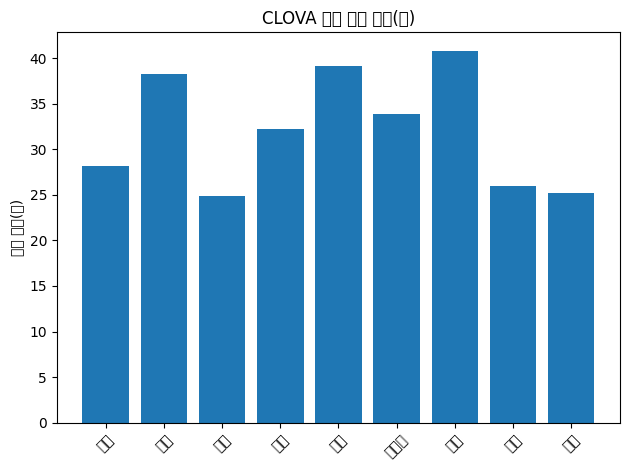

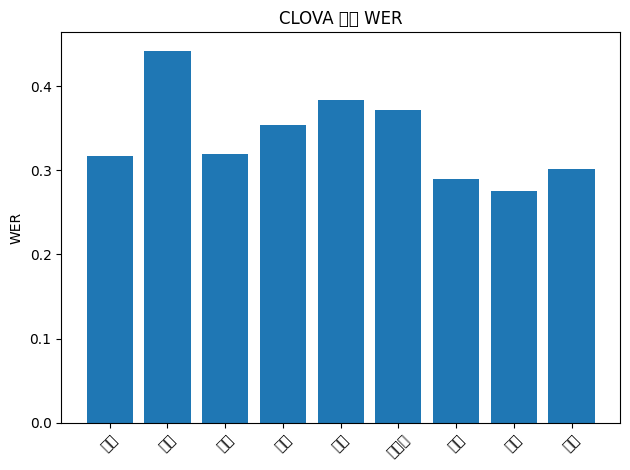

C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\inwoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\inwoo\AppData\Roaming\Python\

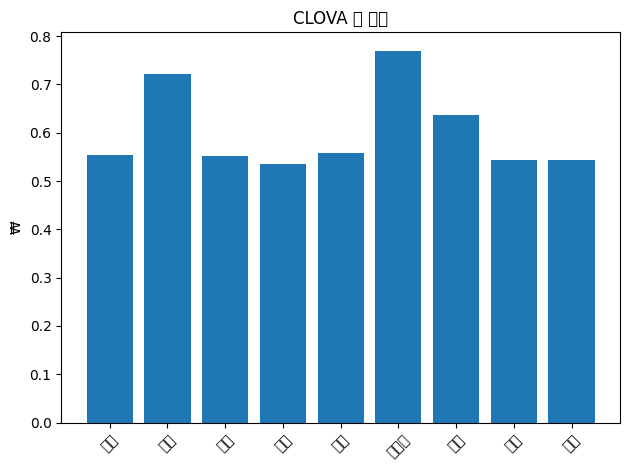

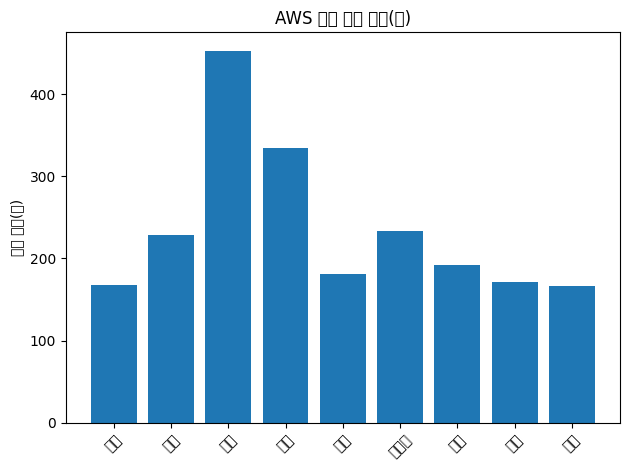

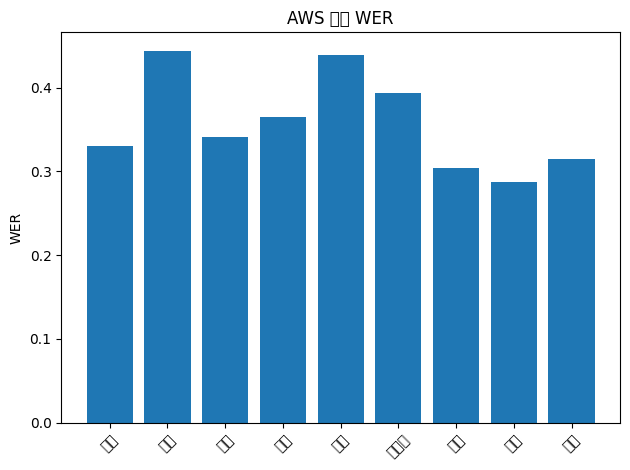

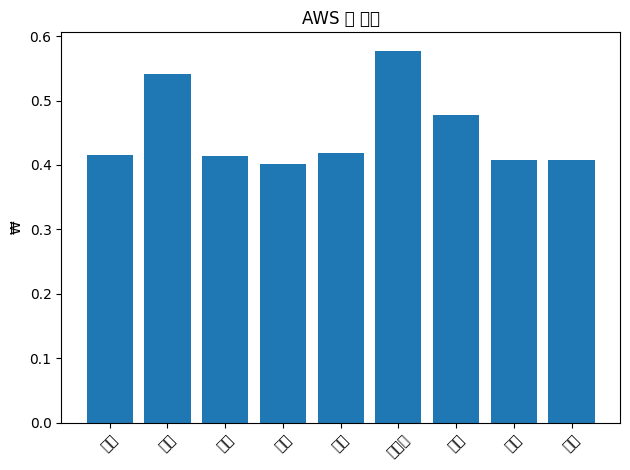

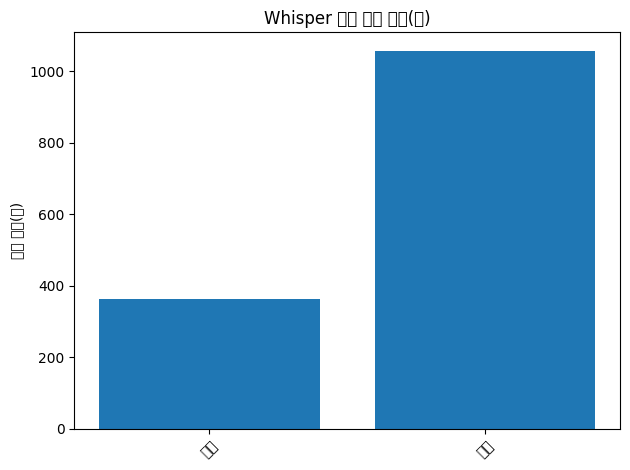

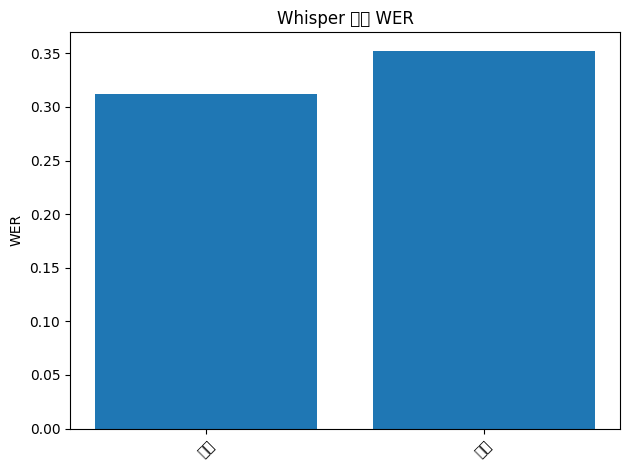

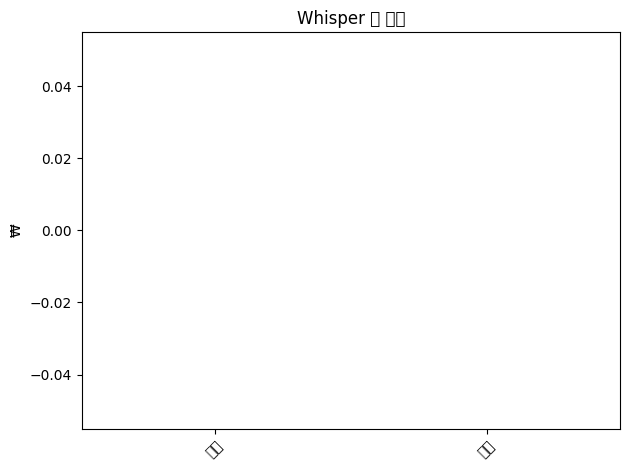

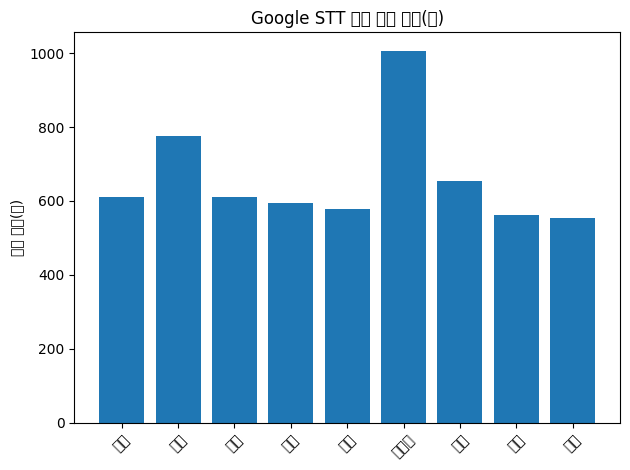

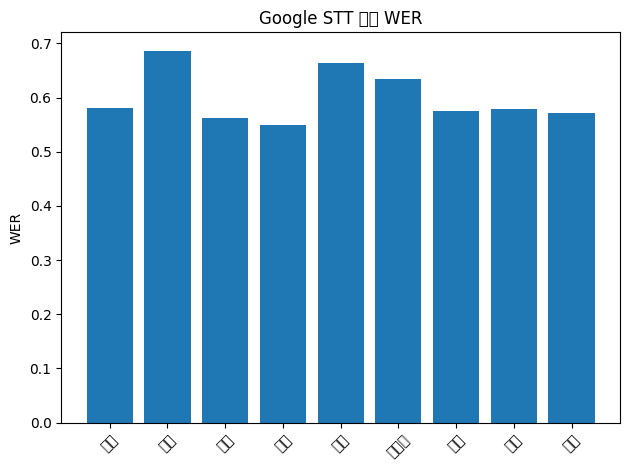

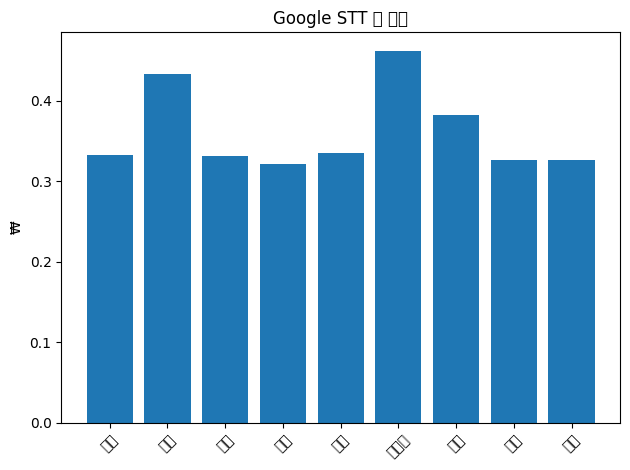

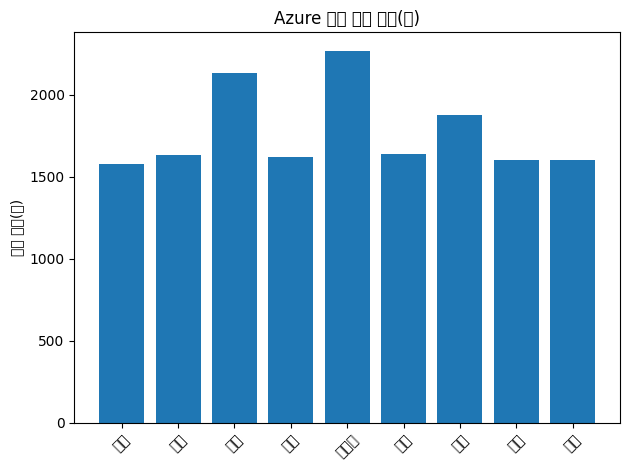

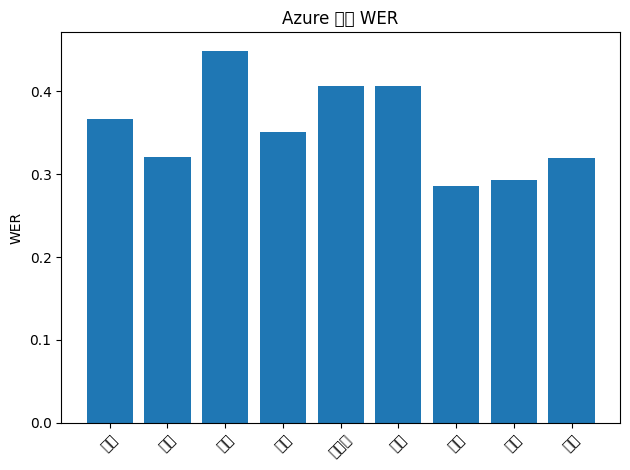

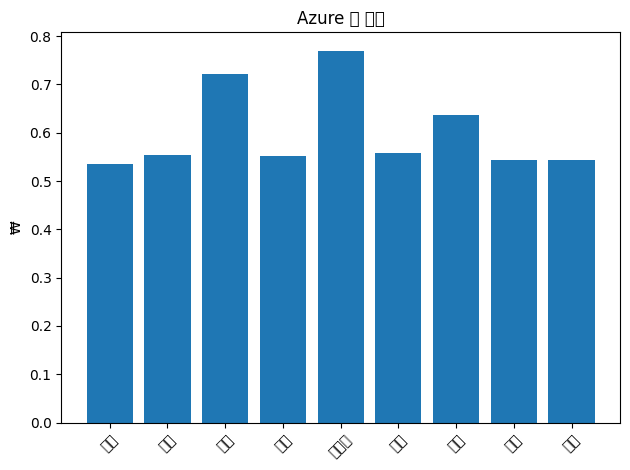

C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 50644 (\N{HANGUL SYLLABLE EN}) missing from fon

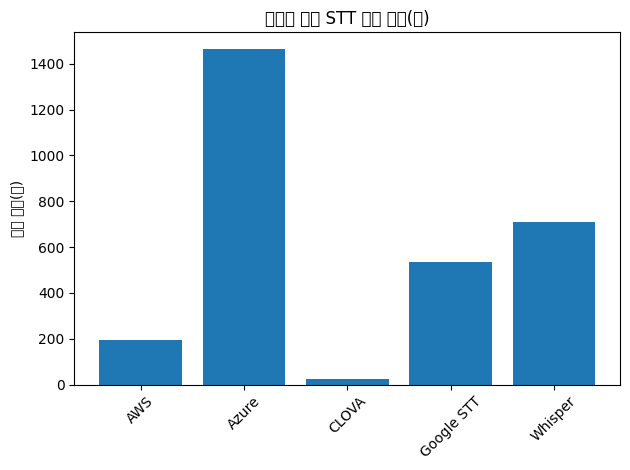

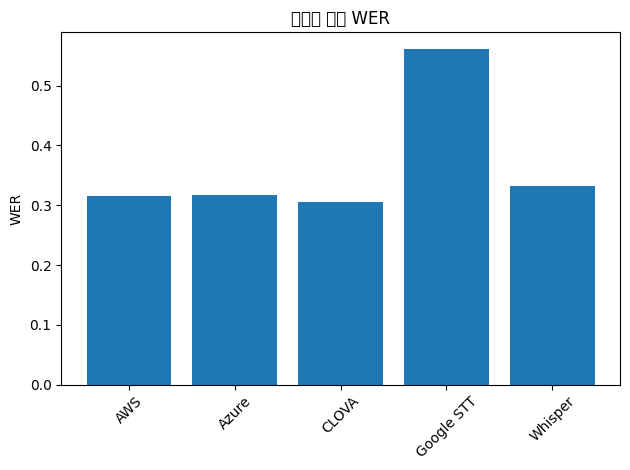

C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\3509727750.py:71: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\inwoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\inwoo\AppData\Roaming\Python\

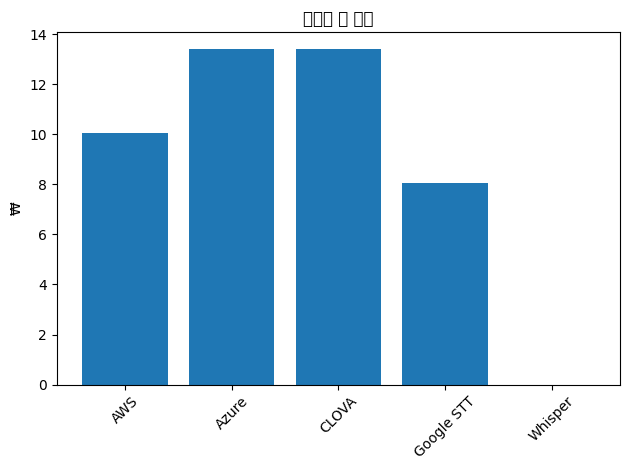

In [ ]:
root_audio_dir = './VS1/data'
root_script_dir = './VS1/data'
engines = [
    "Whisper",
    "CLOVA",
    "Google STT",
    "AWS",
    "Azure"]
worker = None
reuslts = []
results = main_gpu(root_audio_dir, root_script_dir, engines, worker)

In [54]:
 # 6) cudf DataFrame + 집계
gdf = pd.DataFrame(results)

    # 8) 파일별 전사결과도 별도 CSV로
gdf.to_csv(
        'stt_results.csv', index=False, encoding='utf-8-sig'
    )
print("✅ stt_results.csv 저장 완료")

✅ stt_results.csv 저장 완료


In [56]:
%pip uninstall torch torchaudio torchvision
%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

^C
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%pip3` not found.


In [57]:
!pip show torch

Name: torch
Version: 2.8.0.dev20250413+cu128
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\users\inwoo\appdata\local\programs\python\python39\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: timm, torchaudio, torchvision


In [14]:
%pip show torch

Name: torch
Version: 2.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\Users\inwoo\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: accelerate, openai-whisper, torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [ ]:
if torch.cuda.is_available() :
    print("cuda" )
else :
    print("cpu")
print(torch.version.cuda)

cpu
None


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
whisper_model = whisper.load_model("small", device=device)
print("whisepr model")
whisper_model.device

100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 114MiB/s]


whisepr model


device(type='cpu')

In [59]:
stt_whisper(r"D:\dasom\VS1\data\정치\SRBAA21000003.wav")

'텔레그램 박사방에서 성착취 물을 재작 공유한 혐의로 기소된 조즈빈에게 검찰이 무기징역을 구형했습니다. 조 씨는 작년 5월부터 올해 2월까지 여성들을 협박해서 성착취 영상물을 촬영한 뒤 판매하고 유포한 혐의로 구속 기소됐는데요. 다음 달에 열리는 1심 선고에서 어떤 처벌을 받게 될지 지켜보도록 하겠습니다. 10월 22일 목요일에 함께하는 더룸. 이번 정부 들어서 23번의 부동산 정책이 나왔습니다만 전세대란이 더 기승을 부리고 있죠. 부동산 시장을 안정시킬 대책은 없을까 알아보겠고요. 전망 좋은 방 기대해 주십시오. 오늘 국감에 출석한 윤석열 검찰총장이 추미애 법무부 장관을 겨냥해서 쏟아낸 작심 발언들을 분석해 보겠습니다. 네, 이재용 삼성전자 부회장의 경영권 불법 승계 의혹에 대한 첫 번째 공판이 오늘 열렸습니다. 사건의 핵심 쟁점을 짚어보고요. 오늘 재판에서 어떤 발언들이 나왔는지 알아보입니다. 더룸 2부도 채널 고정해 주세요. 시사를 쉽고 재미있게 전달하는 더룸. 지금부터 시작합니다. 오늘 하루 관심이 집중했던 화재의 사진 준비했습니다. 지금부터 두 눈을 크게 뜨시고 두 장의 사진을 비교해 보시기 바랍니다. 자세히 보시면요. 똑같은 장소에서 찍은 두 장의 사진 어떤 점이 다른지 아시겠죠? 전국적으로 독감 예방접종을 맞은 후 사망한 사례가 잇따르면서 한국건강관리협회에 독감 예방접종을 하려는 시민들의 발걸음이 뚝 끊겼습니다. 시민들은 무료 독감 맞기가 무섭다는 의견부터 정부를 믿고 독감 예방접종 시기를 놓치기 전에 맞아야 한다는 의견까지 다양한 목소리를 내고 있습니다. 정은경 질병관리본부청장은 독감 백신 접종 이후 사망자가 잇따르는 것과 관련해 연관성이 확인되지 않았다며 예방접종 사업을 계속 추진하겠다는 입장을 밝혔습니다. 하루 빨리 독감 백신 접종 후 사망한 원인을 밝혀서 시민들이 더는 불안감을 겪지 않도록 해야겠습니다. 조연아 A시픽 두 번째 화제 영상 준비했습니다. 윤석열 검찰총장이 오늘 국정감사에서 과거 검찰의 고문 취사 사건에 대해 팻 죽이겠다는 발언

In [ ]:
domains = [
    d for d in os.listdir(root_script_dir)
    if os.path.isdir(os.path.join(root_script_dir, d))
]
print(domains)
whisper_results = []

for domain in domains:
    script_dir = os.path.join(root_script_dir, domain)
    audio_dir = os.path.join(root_audio_dir, domain)

    basenames = [
        os.path.splitext(os.path.basename(p))[0]
        for p in glob.glob(os.path.join(script_dir, '*.txt'))
    ]

    for b in basenames:
        # process_one_gpu 대신 process_one_serial 같은 함수로 대체하거나
        # process_one_gpu를 순차 호출(내부에서 GPU를 한 번에 하나만 쓰게 처리해야 함)
        result = process_one_gpu(audio_dir, script_dir, b, "Whisper")
        whisper_results.append(result)



['경제', '교육', '사회', '생활', '세계', '스포츠', '연예', '의료', '정치']
Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous
Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous
Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous
Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous
Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous


Exception in thread Thread-1888 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\inwoo\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1075, in _bootstrap_inner


Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous
Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous
Error: cannot reshape tensor of 0 elements into shape [1, 0, 16, -1] because the unspecified dimension size -1 can be any value and is ambiguous


    self.run()
  File "C:\Users\inwoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 766, in run_closure


Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)


    _threading_Thread_run(self)
  File "c:\Users\inwoo\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\inwoo\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1601, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
MemoryError


Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
Error: Expected key.size(1) == value.size(1) to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement r

In [ ]:
 # 6) cudf DataFrame + 집계
gdf = pd.DataFrame(whisper_results)

    # 8) 파일별 전사결과도 별도 CSV로
gdf.to_csv(
        'stt_whisper_results.csv', index=False, encoding='utf-8-sig'
    )
print("✅ stt_whisper_results.csv 저장 완료")

돋움체 폰트를 찾지 못했습니다.
📋 STT 시스템별 wer / 처리 시간 / 비용 요약 (단위: %, 초, 원)


,engine,wer,stt_time_sec,cost_usd
0,AWS,0.3155,194.0021,372.3
1,Azure,0.3170,1463.4995,496.4
2,CLOVA,0.3048,25.4029,496.4
3,Google STT,0.5611,533.4104,297.9
4,Whisper,0.3320,710.2005,0.0


findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
findfont: Font family 'Dotum' not found.
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\241811685.py:58: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inwoo\AppData\Local\Temp\ipykernel_3212\241811685.py:58: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C

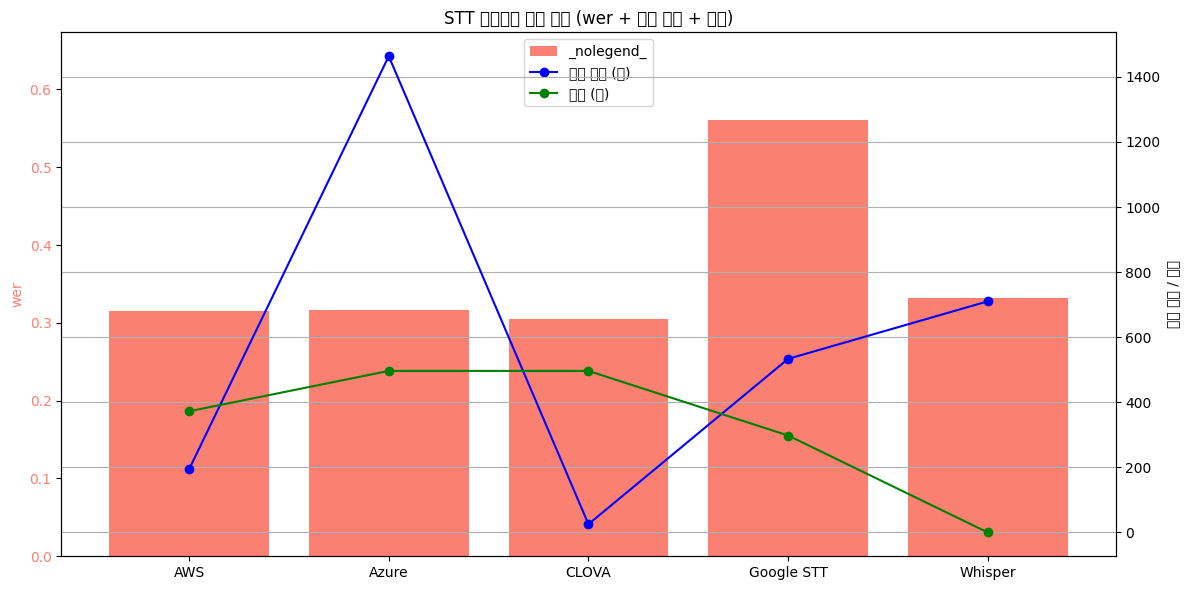

In [49]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from IPython.display import display

def plot_stt_summary_wer(summary_df):
    font_path = ""
    font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    for font in font_list:
        if "Dotum Regular" in font or "Dotum" in font:
            font_path = font
            break
    if font_path:
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
        plt.rcParams["axes.unicode_minus"] = False
    else:
        print("돋움체 폰트를 찾지 못했습니다.")
        plt.rcParams["font.family"] = "Dotum"
        plt.rcParams["axes.unicode_minus"] = False



    # ✅ 비용 단위 정리
    summary_df = summary_df.copy()
    summary_df["wer"] = summary_df["wer"].round(4)
    summary_df["cost_usd"] = (summary_df["cost_usd"] * 1000).round(2)  # 원 단위

    # 📊 표 출력
    print("📋 STT 시스템별 wer / 처리 시간 / 비용 요약 (단위: %, 초, 원)")
    display(summary_df[["engine", "wer", "stt_time_sec", "cost_usd"]])

    # 🎨 시각화
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # wer (막대)
    bar_container = ax1.bar(summary_df["engine"], summary_df["wer"],
                            color="salmon", label="wer")
    ax1.set_ylabel("wer", color="salmon")
    ax1.tick_params(axis='y', labelcolor="salmon")
    ax1.set_ylim(0, max(summary_df["wer"]) * 1.2)

    # 처리 시간/비용 (선)
    ax2 = ax1.twinx()
    line1 = ax2.plot(summary_df["engine"], summary_df["stt_time_sec"],
                     color="blue", marker="o", label="처리 시간 (초)")
    line2 = ax2.plot(summary_df["engine"], summary_df["cost_usd"],
                     color="green", marker="o", label="비용 (원)")  # ✅ 초록색으로 변경
    ax2.set_ylabel("처리 시간 / 비용", color="black")
    ax2.tick_params(axis='y')

    # 범례 병합
    lines = [bar_container[0]] + line1 + line2
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper center")

    plt.title("STT 시스템별 성능 비교 (wer + 처리 시간 + 비용)")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

#######tnwjd
df_results = pd.DataFrame(results)
summary_df = df_results.groupby(["engine"]).agg({
    "stt_time_sec": "mean",
    "wer": "mean",
    "cost_usd": "mean"
}).reset_index().round(4)

plot_stt_summary_wer(summary_df)
